In [1]:
import os 
import supervision as sv
from transformers import DetrForObjectDetection, DetrImageProcessor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
from inference2 import loadModel, inference4, inference2, inference3
from img2pdf import readPDF, savePDF
from createGroundTruth import create_ground_truth_dict
import time
import torchvision
from torchvision.ops import box_iou
import torch
import pytorch_lightning
import cv2
import random
import numpy as np
import pandas as pd

d:\Object Detection\object_detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101")

In [170]:
## CocoDetection Class 

# settings
ANNOTATION_FILE_NAME = r"result.json"
TRAIN_DIRECTORY = os.path.join(r"dataset2", r"train")
VAL_DIRECTORY = os.path.join(r"dataset2", r"val")
TEST_DIRECTORY = os.path.join(r"dataset2", r"test")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target
    
TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 130
Number of validation examples: 32
Number of test examples: 19


In [4]:
# ## CocoDetection Class 

# # settings
# ANNOTATION_FILE_NAME = r"result.json"
# TRAIN_DIRECTORY = os.path.join(r"dataset", r"train")
# VAL_DIRECTORY = os.path.join(r"dataset", r"val")
# TEST_DIRECTORY = os.path.join(r"dataset", r"test")

# class CocoDetection(torchvision.datasets.CocoDetection):
#     def __init__(
#         self,
#         image_directory_path: str,
#         image_processor,
#         train: bool = True
#     ):
#         annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
#         super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
#         self.image_processor = image_processor

#     def __getitem__(self, idx):
#         images, annotations = super(CocoDetection, self).__getitem__(idx)
#         image_id = self.ids[idx]
#         annotations = {'image_id': image_id, 'annotations': annotations}
#         encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
#         pixel_values = encoding["pixel_values"].squeeze()
#         target = encoding["labels"][0]

#         return pixel_values, target
    
# TRAIN_DATASET = CocoDetection(
#     image_directory_path=TRAIN_DIRECTORY+'/images',
#     image_processor=image_processor,
#     train=True)
# VAL_DATASET = CocoDetection(
#     image_directory_path=VAL_DIRECTORY+'/images',
#     image_processor=image_processor,
#     train=False)
# TEST_DATASET = CocoDetection(
#     image_directory_path=TEST_DIRECTORY+'/images',
#     image_processor=image_processor,
#     train=False)

# print("Number of training examples:", len(TRAIN_DATASET))
# print("Number of validation examples:", len(VAL_DATASET))
# print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 145
Number of validation examples: 18
Number of test examples: 18


In [164]:
CHECKPOINT = "facebook/detr-resnet-50"

# Best Performing Model
MODEL_PATH = "models/DETR-run7"

# Doesnt Work
# MODEL_101 = 'facebook/detr-resnet-101'
# CHECKPOINT_101 = 'facebook/detr-resnet-101'

# Older Model
# MODEL_PATH = "models/DETR-run4"


## Load Model
def loadModel(MODEL_PATH, CHECKPOINT):
    model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
    image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
    return model, image_processor

In [165]:
from transformers import DetrForObjectDetection
import torch
from collections import OrderedDict

# Initialize the model architecture
model, image_processor = loadModel(MODEL_PATH=MODEL_PATH, CHECKPOINT=CHECKPOINT)

In [168]:

# model, image_processor = loadModel(MODEL_PATH=MODEL_101, CHECKPOINT=CHECKPOINT_101)

# Load your checkpoint
checkpoint = torch.load("models/DETR-run7/ModelCheckpoints2/detr-epoch=47-val_loss=0.53.ckpt", map_location='cpu')

# # Get the state dict
state_dict = checkpoint['state_dict']

# # # Remove the 'model.model.' prefix from the state dict keys
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("model.model.", "")
    new_state_dict[name] = v

# # # Load the modified state dict
model.load_state_dict(new_state_dict, strict=False)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Model loaded successfully!")

Model loaded successfully!


In [171]:
## Create Ground Truth Dictionary
ground_truth = create_ground_truth_dict('dataset2/test/result.json')

# For Older models
# ground_truth = create_ground_truth_dict('dataset/test/images/result.json')

In [230]:
ground_truth

{'images/4fdca17b-drawing_7.png': {'boxes': [[109.90697674418603,
    136.0,
    151.02325581395348,
    176.32558139534885],
   [542.4186046511628,
    364.51162790697674,
    634.9302325581396,
    407.2093023255814],
   [426.1860465116279,
    460.9767441860465,
    535.3023255813954,
    487.86046511627916],
   [214.27906976744188,
    517.9069767441861,
    290.9767441860465,
    547.1627906976744]],
  'labels': [3, 1, 0, 2]},
 'images/8318502d-drawing_15.png': {'boxes': [[411.16279069767444,
    68.0,
    448.3255813953489,
    105.95348837209303],
   [608.8372093023256,
    370.83720930232556,
    699.7674418604652,
    406.4186046511627],
   [43.48837209302325,
    529.7674418604652,
    118.6046511627907,
    555.0697674418604],
   [389.8139534883721,
    476.79069767441865,
    439.62790697674416,
    498.9302325581396],
   [219.81395348837205,
    143.90697674418604,
    290.18604651162786,
    162.09302325581393]],
  'labels': [3, 1, 0, 2, 2]},
 'images/eef413ab-drawing_22.

In [172]:
categories = TEST_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
id2label

{0: 'bar-scale', 1: 'color-stamp', 2: 'detail-labels', 3: 'north-sign'}

In [235]:
## Inference Function
IMAGE_FOLDER = 'Temp/images'
CONFIDENCE_THRESHOLD = 0.6
IOU_THRESHOLD = 0.7

def inference(image_folder, CONFIDENCE_THRESHOLD, IOU_THRESHOLD):
    results_dict = {}
    
    for img in os.listdir(image_folder):
        IMAGE_PATH = os.path.join(image_folder, img)
        print(f"Processing {IMAGE_PATH}")

        image = cv2.imread(IMAGE_PATH)
        inputs = image_processor(images=image, return_tensors='pt')

        # Move inputs to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Get ground truth for this image
        target = ground_truth.get(img, {'boxes': torch.empty((0, 4)), 'labels': torch.empty((0,), dtype=torch.long)})
        # target = {k: torch.tensor(v).to(model.device) for k, v in target.items()}
        # target = {k: v.clone().detach().to(model.device) for k, v in target.items()}
        target = {k: v for k, v in target.items()}
        # print(target)
        with torch.no_grad():
            outputs = model(**inputs)
            
            # Post-process
            target_sizes = torch.tensor([image.shape[:2]]).to(model.device)
            results = image_processor.post_process_object_detection(
                outputs=outputs,
                threshold=CONFIDENCE_THRESHOLD,
                target_sizes=target_sizes
            )[0]
        
        # detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_THRESHOLD)
        detections = sv.Detections.from_transformers(transformers_results=results)
        labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
        print(labels)
        box_annotator = sv.BoxAnnotator()
        frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)
        Image.fromarray(frame).save(f"Temp/results/annotated_{img}", format='PNG')
        # results.append([IMAGE_PATH.replace('Temp/', ''), result])
        results_dict[IMAGE_PATH.replace('Temp/', '')] = results
        # all_labels = {1, 2, 3, 4}
        
        # results_dict[IMAGE_PATH.replace('Temp/', '')], results_dict['missing_labels'] = results, (all_labels - set(results['labels'].detach))
        # print(results['labels'])}
        # labels_df['missing_labels'] = labels_df['labels'].apply(lambda x: all_labels - x)
    return results_dict

In [236]:
results = inference(IMAGE_FOLDER, 0.5, 0.6)

Processing Temp/images\11913d58-drawing_88.png
['LABEL_1 0.53', 'LABEL_3 0.91', 'LABEL_2 0.70', 'LABEL_2 0.64', 'LABEL_3 0.78', 'LABEL_2 0.95']
Processing Temp/images\17bd5f92-drawing_106.png
['LABEL_2 0.95', 'LABEL_0 0.88', 'LABEL_3 0.82', 'LABEL_2 0.94', 'LABEL_2 0.95', 'LABEL_1 0.82']
Processing Temp/images\2067578c-drawing_24.png
['LABEL_2 0.89', 'LABEL_3 0.92', 'LABEL_0 0.87', 'LABEL_2 0.85']
Processing Temp/images\2466f98b-drawing_67.png
['LABEL_0 0.83', 'LABEL_1 0.83', 'LABEL_2 0.91', 'LABEL_2 0.97', 'LABEL_0 0.87', 'LABEL_0 0.77', 'LABEL_0 0.71', 'LABEL_3 0.61', 'LABEL_2 0.94']
Processing Temp/images\3108be30-drawing_43.png


KeyboardInterrupt: 

In [138]:
results

{'images\\e4488dcd-outfile163.png': {'scores': tensor([0.9003, 0.9461, 0.9580, 0.5659, 0.7615, 0.6443, 0.8718, 0.9393, 0.9363,
          0.9125]),
  'labels': tensor([1, 4, 3, 3, 3, 3, 3, 3, 3, 2]),
  'boxes': tensor([[ 51.0844, 519.2147, 173.7808, 555.1384],
          [ 38.4558,  69.7419,  84.7549, 111.7220],
          [414.7876, 229.3402, 480.2212, 259.4869],
          [264.4022, 417.2076, 295.4213, 436.8293],
          [265.4215, 396.1916, 303.8947, 418.6251],
          [ 76.8188, 427.2198, 133.6106, 445.9435],
          [ 73.5163, 421.4941, 139.9279, 448.7569],
          [234.8455, 163.1137, 298.5825, 187.6942],
          [616.2727, 289.4289, 670.7613, 310.4396],
          [477.8539, 510.3906, 572.5653, 556.4916]])},
 'images\\eb6f4ea9-output_folder87.png': {'scores': tensor([0.8908, 0.9492, 0.8376, 0.9139]),
  'labels': tensor([1, 4, 2, 3]),
  'boxes': tensor([[ 56.9786, 524.5278, 151.3273, 551.2535],
          [ 35.5197, 109.3372,  74.6260, 146.9118],
          [250.2004, 487.569

### Create Predictions DataFrame

In [118]:
# results

In [175]:
predictions_df = pd.DataFrame()
for k in results:
    df = pd.DataFrame(results[k]['boxes'].detach().to('cpu').numpy(), columns=['x1', 'y1', 'x2', 'y2'])
    df['labels'] = results[k]['labels'].detach().to('cpu').numpy()
    df['image'] = k.replace('images\\', '')
    # print(df['image'])
    predictions_df = pd.concat([predictions_df, df], ignore_index=True)
predictions_df.shape

(110, 6)

In [176]:
predictions_df['labels'].value_counts()

labels
2    51
3    21
1    20
0    18
Name: count, dtype: int64

In [177]:
predictions_df['image'].unique()

array(['11913d58-drawing_88.png', '17bd5f92-drawing_106.png',
       '2067578c-drawing_24.png', '2466f98b-drawing_67.png',
       '3108be30-drawing_43.png', '449d473c-drawing_25.png',
       '4fdca17b-drawing_7.png', '5acab2e6-drawing_64.png',
       '8318502d-drawing_15.png', '92e4c80c-drawing_45.png',
       'a01b4a37-drawing_168.png', 'a34b8e8d-drawing_44.png',
       'a55f419c-drawing_48.png', 'af0c0b68-drawing_76.png',
       'b6c7e8be-drawing_56.png', 'cc5b592c-drawing_113.png',
       'e616d66b-drawing_123.png', 'eef413ab-drawing_22.png',
       'f601361a-drawing_42.png'], dtype=object)

### Create Ground Truths DataFrame

In [178]:
ground_truth_df = pd.DataFrame()
for k in ground_truth:
    df = pd.DataFrame(ground_truth[k]['boxes'], columns=['x1', 'y1', 'x2', 'y2'])
    df['labels'] = ground_truth[k]['labels']
    # print(k)
    df['image'] = k.replace('images/', '')
    # print(df['image'])
    ground_truth_df = pd.concat([ground_truth_df, df], ignore_index=True)
    
ground_truth_df.shape

(116, 6)

In [179]:
ground_truth_df['labels'].value_counts()

labels
2    50
0    27
3    22
1    17
Name: count, dtype: int64

## Sort DFs

In [180]:
ground_truth_df = ground_truth_df.sort_values(by=['image', 'labels', 'y1', 'x1'])
predictions_df = predictions_df.sort_values(by=['image', 'labels', 'y1', 'x1'])

### Row Count

In [181]:
ground_truth_df['row_count'] = ground_truth_df.groupby(['image', 'labels']).cumcount() + 1
predictions_df['row_count'] = predictions_df.groupby(['image', 'labels']).cumcount() + 1

In [182]:
# ground_truth_df.head(10)
predictions_df.head(10)

,x1,y1,x2,y2,labels,image,row_count
0,278.494934,528.815002,360.598358,558.032288,1,11913d58-drawing_88.png,1
5,623.942871,267.716156,710.059937,292.252167,2,11913d58-drawing_88.png,1
2,216.318863,518.310669,292.160645,546.712708,2,11913d58-drawing_88.png,2
3,214.266266,519.274414,292.641144,547.464417,2,11913d58-drawing_88.png,3
1,46.732620,70.202827,80.939987,104.400940,3,11913d58-drawing_88.png,1
4,39.997841,352.875702,75.729424,385.811737,3,11913d58-drawing_88.png,2
7,48.061279,513.471252,136.894226,533.420105,0,17bd5f92-drawing_106.png,1
11,616.694702,385.592316,695.228088,415.344025,1,17bd5f92-drawing_106.png,1
9,425.991577,109.794601,497.029144,136.679779,2,17bd5f92-drawing_106.png,1
10,78.777405,263.343567,174.254745,290.355896,2,17bd5f92-drawing_106.png,2


## Merge The DataFrames for Comparison

In [183]:
merged_df = pd.merge(ground_truth_df, predictions_df, on=['image', 'labels', 'row_count'], how='outer', suffixes=('_gt', '_pred'), validate='many_to_many')

In [184]:
merged_df.head(12)

,x1_gt,y1_gt,x2_gt,y2_gt,labels,image,row_count,x1_pred,y1_pred,x2_pred,y2_pred
0,626.232558,409.581395,732.186047,429.348837,0,11913d58-drawing_88.png,1,NaN,NaN,NaN,NaN
1,279.116279,529.767442,363.720930,559.023256,1,11913d58-drawing_88.png,1,278.494934,528.815002,360.598358,558.032288
2,626.232558,266.465116,713.209302,290.186047,2,11913d58-drawing_88.png,1,623.942871,267.716156,710.059937,292.252167
3,217.441860,518.697674,278.325581,542.418605,2,11913d58-drawing_88.png,2,216.318863,518.310669,292.160645,546.712708
4,NaN,NaN,NaN,NaN,2,11913d58-drawing_88.png,3,214.266266,519.274414,292.641144,547.464417
5,46.651163,66.418605,83.813953,105.162791,3,11913d58-drawing_88.png,1,46.732620,70.202827,80.939987,104.400940
6,39.534884,351.069767,75.116279,389.813953,3,11913d58-drawing_88.png,2,39.997841,352.875702,75.729424,385.811737
7,46.651163,515.534884,136.790698,535.302326,0,17bd5f92-drawing_106.png,1,48.061279,513.471252,136.894226,533.420105
8,617.534884,386.651163,695.813953,419.860465,1,17bd5f92-drawing_106.png,1,616.694702,385.592316,695.228088,415.344025
9,426.976744,108.325581,498.139535,136.790698,2,17bd5f92-drawing_106.png,1,425.991577,109.794601,497.029144,136.679779


## Calculate IOU

In [185]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
    - box1: (x1, y1, x2, y2) coordinates of the first bounding box
    - box2: (x1, y1, x2, y2) coordinates of the second bounding box
    
    Returns:
    - iou: Intersection over Union (IoU) value
    """
    
    # Unpack the coordinates of the two boxes
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Calculate the (x, y) coordinates of the intersection rectangle
    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)
    
    # Calculate the area of the intersection rectangle
    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height
    
    # Calculate the area of both bounding boxes
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    
    # Calculate the union area
    union_area = box1_area + box2_area - inter_area
    
    # Calculate the IoU
    iou = inter_area / union_area if union_area != 0 else 0
    
    return iou

In [186]:
merged_df['iou'] = merged_df.apply(lambda x: calculate_iou((x['x1_gt'], x['y1_gt'], x['x2_gt'], x['y2_gt']), (x['x1_pred'], x['y1_pred'], x['x2_pred'], x['y2_pred'])), axis=1)

In [187]:
# merged_df.head(4)
# merged_df.loc[merged_df['image'] == 'e616d66b-drawing_123.png']
merged_df['image'].unique()

array(['11913d58-drawing_88.png', '17bd5f92-drawing_106.png',
       '2067578c-drawing_24.png', '2466f98b-drawing_67.png',
       '3108be30-drawing_43.png', '449d473c-drawing_25.png',
       '4fdca17b-drawing_7.png', '5acab2e6-drawing_64.png',
       '8318502d-drawing_15.png', '92e4c80c-drawing_45.png',
       'a01b4a37-drawing_168.png', 'a34b8e8d-drawing_44.png',
       'a55f419c-drawing_48.png', 'af0c0b68-drawing_76.png',
       'b6c7e8be-drawing_56.png', 'cc5b592c-drawing_113.png',
       'e616d66b-drawing_123.png', 'eef413ab-drawing_22.png',
       'f601361a-drawing_42.png'], dtype=object)

## Calculate TP, FP, FN

In [188]:
TP, FP, FN = 0, 0, 0
merged_df['result'] = ''
for i in range(merged_df.shape[0]):
    # if merged_df['image'][i] == '5acab2e6-drawing_64.png':
    if merged_df['iou'][i] > 0.6:
        print('True Positive')
        print(f"IoU {i}: {merged_df['iou'][i]:.4f}")
        TP += 1
        # df.loc[row_indexer, "col"] = values
        merged_df.loc[i, 'result'] = 'TP'
        # merged_df['result'][i] = 'TP'
    elif merged_df['iou'][i] == 0:
        print('False Positive')
        print(f"IoU {i}: {merged_df['iou'][i]:.4f}")
        FP += 1
        merged_df.loc[i, 'result'] = 'FP'
    elif pd.isna(merged_df['iou'][i]):
        if pd.isna(merged_df['x1_pred'][i]):
            print('False Negative')
            FN += 1
            merged_df.loc[i, 'result'] = 'FN'
        if pd.isna(merged_df['x1_gt'][i]):
            print('False Positive')
            FP += 1
            merged_df.loc[i, 'result'] = 'FP'
    else: 
        print('False Positive')
        print(f"IoU {i}: {merged_df['iou'][i]:.4f}")
        FP += 1
        merged_df.loc[i, 'result'] = 'FP'
    # merged_df['result'][i] = 'FP'

False Negative
True Positive
IoU 1: 0.8958
True Positive
IoU 2: 0.8216
True Positive
IoU 3: 0.6705
False Positive
True Positive
IoU 5: 0.8125
True Positive
IoU 6: 0.8269
True Positive
IoU 7: 0.8068
True Positive
IoU 8: 0.8236
True Positive
IoU 9: 0.9178
True Positive
IoU 10: 0.7355
True Positive
IoU 11: 0.7931
True Positive
IoU 12: 0.8350
False Positive
IoU 13: 0.0000
False Negative
True Positive
IoU 15: 0.8376
True Positive
IoU 16: 0.8870
True Positive
IoU 17: 0.7583
False Positive
IoU 18: 0.0000
False Positive
IoU 19: 0.0000
False Positive
IoU 20: 0.0000
False Positive
IoU 21: 0.0000
True Positive
IoU 22: 0.6801
True Positive
IoU 23: 0.9080
True Positive
IoU 24: 0.6815
True Positive
IoU 25: 0.8480
True Positive
IoU 26: 0.7552
True Positive
IoU 27: 0.7710
True Positive
IoU 28: 0.8548
True Positive
IoU 29: 0.8003
True Positive
IoU 30: 0.7402
True Positive
IoU 31: 0.8353
True Positive
IoU 32: 0.9389
True Positive
IoU 33: 0.8790
False Positive
IoU 34: 0.5982
True Positive
IoU 35: 0.6150


In [189]:
merged_df.loc[merged_df['image'] == 'fae5fc59-outfile115.png']

,x1_gt,y1_gt,x2_gt,y2_gt,labels,image,row_count,x1_pred,y1_pred,x2_pred,y2_pred,iou,result


In [190]:
print("True Positive - ", TP)
print("False Positive - ", FP)
print("False Negative - ", FN)

True Positive -  97
False Positive -  13
False Negative -  11


In [191]:
print("Accuracy - ", TP/(TP+FP+FN))
print("Precision - ", TP/(TP+FP))
print("Recall - ", TP/(TP+FN))

Accuracy -  0.8016528925619835
Precision -  0.8818181818181818
Recall -  0.8981481481481481


### ERROR

In [192]:
merged_df.loc[merged_df['image'] == "ee2b485d-outfile161.png"]

,x1_gt,y1_gt,x2_gt,y2_gt,labels,image,row_count,x1_pred,y1_pred,x2_pred,y2_pred,iou,result


## Class Wise Accuracy

### Bar Scale (1)

In [193]:
id2label

{0: 'bar-scale', 1: 'color-stamp', 2: 'detail-labels', 3: 'north-sign'}

In [194]:
TP, FN, FP = merged_df.loc[merged_df['labels']==0]['result'].value_counts()

In [195]:
print(f"Accuracy = {TP/(TP+FP+FN):.4f}")
print(f"Precision = {TP/(TP+FP):.4f}")
print(f"Recall = {TP/(TP+FN):.4f}")

Accuracy = 0.4444
Precision = 0.6667
Recall = 0.5714


### Color Stamp (2)

In [199]:
TP, FP = merged_df.loc[merged_df['labels']==1]['result'].value_counts()

In [200]:
FN = 0

In [201]:
print(f"Accuracy = {TP/(TP+FP+FN):.4f}")
print(f"Precision = {TP/(TP+FP):.4f}")
print(f"Recall = {TP/(TP+FN):.4f}")

Accuracy = 0.8000
Precision = 0.8000
Recall = 1.0000


### Detail Labels (3)

In [203]:
TP, FP, FN = merged_df.loc[merged_df['labels']==2]['result'].value_counts()
# FN = 0

In [204]:
print(f"Accuracy = {TP/(TP+FP+FN):.4f}")
print(f"Precision = {TP/(TP+FP):.4f}")
print(f"Recall = {TP/(TP+FN):.4f}")

Accuracy = 0.9231
Precision = 0.9412
Recall = 0.9796


### North Sign (4)

In [209]:
TP, FN = merged_df.loc[merged_df['labels']==3]['result'].value_counts()
FP = 0

In [210]:
print(f"Accuracy = {TP/(TP+FP+FN):.4f}")
print(f"Precision = {TP/(TP+FP):.4f}")
print(f"Recall = {TP/(TP+FN):.4f}")

Accuracy = 0.9545
Precision = 1.0000
Recall = 0.9545


## Missing Labels in the Image

In [211]:
# predictions_df.groupby('image')['labels'].unique()
labels_df = predictions_df.groupby('image')['labels'].apply(lambda x: set(x)).reset_index()
labels_df


,image,labels
0,11913d58-drawing_88.png,"{1, 2, 3}"
1,17bd5f92-drawing_106.png,"{0, 1, 2, 3}"
2,2067578c-drawing_24.png,"{0, 2, 3}"
3,2466f98b-drawing_67.png,"{0, 1, 2, 3}"
4,3108be30-drawing_43.png,"{0, 1, 2, 3}"
5,449d473c-drawing_25.png,"{0, 1, 2, 3}"
6,4fdca17b-drawing_7.png,"{1, 2, 3}"
7,5acab2e6-drawing_64.png,"{0, 2, 3}"
8,8318502d-drawing_15.png,"{0, 1, 2, 3}"
9,92e4c80c-drawing_45.png,"{0, 1, 2, 3}"


In [214]:
all_labels = {0, 1, 2, 3}

labels_df['missing_labels'] = labels_df['labels'].apply(lambda x: all_labels - x)

In [215]:
labels_df

,image,labels,missing_labels
0,11913d58-drawing_88.png,"{1, 2, 3}",{0}
1,17bd5f92-drawing_106.png,"{0, 1, 2, 3}",{}
2,2067578c-drawing_24.png,"{0, 2, 3}",{1}
3,2466f98b-drawing_67.png,"{0, 1, 2, 3}",{}
4,3108be30-drawing_43.png,"{0, 1, 2, 3}",{}
5,449d473c-drawing_25.png,"{0, 1, 2, 3}",{}
6,4fdca17b-drawing_7.png,"{1, 2, 3}",{0}
7,5acab2e6-drawing_64.png,"{0, 2, 3}",{1}
8,8318502d-drawing_15.png,"{0, 1, 2, 3}",{}
9,92e4c80c-drawing_45.png,"{0, 1, 2, 3}",{}


## Data Information

In [219]:
# Ground Truth
print(f'Number of Labels in Training Data - {ground_truth_df.shape[0]}')
print(f'Bar Scale Count - {ground_truth_df.loc[ground_truth_df["labels"]==0].shape[0]}')
print(f'Color Stamp Count - {ground_truth_df.loc[ground_truth_df["labels"]==1].shape[0]}')
print(f'Detail Label Count - {ground_truth_df.loc[ground_truth_df["labels"]==2].shape[0]}')
print(f'North Sign Count - {ground_truth_df.loc[ground_truth_df["labels"]==3].shape[0]}')

Number of Labels in Training Data - 116
Bar Scale Count - 27
Color Stamp Count - 17
Detail Label Count - 50
North Sign Count - 22


In [223]:
# Predictions
print(f'Number of Labels in Predictions - {predictions_df.shape[0]}')
print(f'Bar Scale Count - {predictions_df.loc[predictions_df["labels"]==0].shape[0]}')
print(f'Color Stamp Count - {predictions_df.loc[predictions_df["labels"]==1].shape[0]}')
print(f'Detail Label Count - {predictions_df.loc[predictions_df["labels"]==2].shape[0]}')
print(f'North Sign Count - {predictions_df.loc[predictions_df["labels"]==3].shape[0]}')

Number of Labels in Predictions - 110
Bar Scale Count - 18
Color Stamp Count - 20
Detail Label Count - 51
North Sign Count - 21


## Trial

In [224]:
! pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [226]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

Testing:  20%|██        | 1/5 [00:14<00:57, 14.27s/it]

Batch true labels: [array([3, 1, 0, 2], dtype=int64), array([3, 1, 0, 2, 2], dtype=int64), array([3, 1, 0, 2, 2, 2], dtype=int64), array([3, 0, 0, 2, 2], dtype=int64)]
Batch predicted labels: [1 3 1 2]


Testing:  40%|████      | 2/5 [00:36<00:56, 18.81s/it]

Batch true labels: [array([3, 1, 0, 2, 2, 2, 2, 2], dtype=int64), array([3, 1, 1, 0, 2, 2, 2, 2], dtype=int64), array([3, 1, 0, 2, 2], dtype=int64), array([3, 1, 0, 0, 2], dtype=int64)]
Batch predicted labels: [0 2 3 2 2 2 1 2 2]


Testing:  60%|██████    | 3/5 [00:49<00:32, 16.43s/it]

Batch true labels: [array([3, 1, 0, 2, 2, 2, 2], dtype=int64), array([3, 1, 0], dtype=int64), array([3, 1, 0, 0, 2, 2], dtype=int64), array([3, 0, 2, 2, 2], dtype=int64)]
Batch predicted labels: [2 3 1 0 2 2 2]


Testing:  80%|████████  | 4/5 [01:03<00:15, 15.43s/it]

Batch true labels: [array([3, 1, 0, 0, 0, 0, 2, 2, 2], dtype=int64), array([3, 3, 1, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int64), array([3, 3, 1, 0, 2, 2], dtype=int64), array([3, 1, 0, 2, 2, 2], dtype=int64)]
Batch predicted labels: [0 1 2 2 0 0 0 3 2]


Testing: 100%|██████████| 5/5 [01:19<00:00, 15.81s/it]

Batch true labels: [array([3, 0, 2, 2, 2], dtype=int64), array([3, 1, 0, 0, 2, 2], dtype=int64), array([3, 3, 1, 0, 0, 2], dtype=int64)]
Batch predicted labels: [0 3 2 2 2]
Time required for testing: 79.03 seconds
True labels: [3 1 0 2 3 1 0 2 2 3 1 0 2 2 2 3 0 0 2 2 3 1 0 2 2 2 2 2 3 1 1 0 2 2]
Predicted labels: [1 3 1 2 0 2 3 2 2 2 1 2 2 2 3 1 0 2 2 2 0 1 2 2 0 0 0 3 2 0 3 2 2 2]
Accuracy: 0.3824
Precision: 0.2828
Recall: 0.2857
F1 Score: 0.2829
Error Rate: 0.6176


Classification Report:
               precision    recall  f1-score   support

    bar-scale       0.14      0.14      0.14         7
  color-stamp       0.40      0.33      0.36         6
detail-labels       0.59      0.67      0.62        15
   north-sign       0.00      0.00      0.00         6

     accuracy                           0.38        34
    macro avg       0.28      0.29      0.28        34
 weighted avg       0.36      0.38      0.37        34



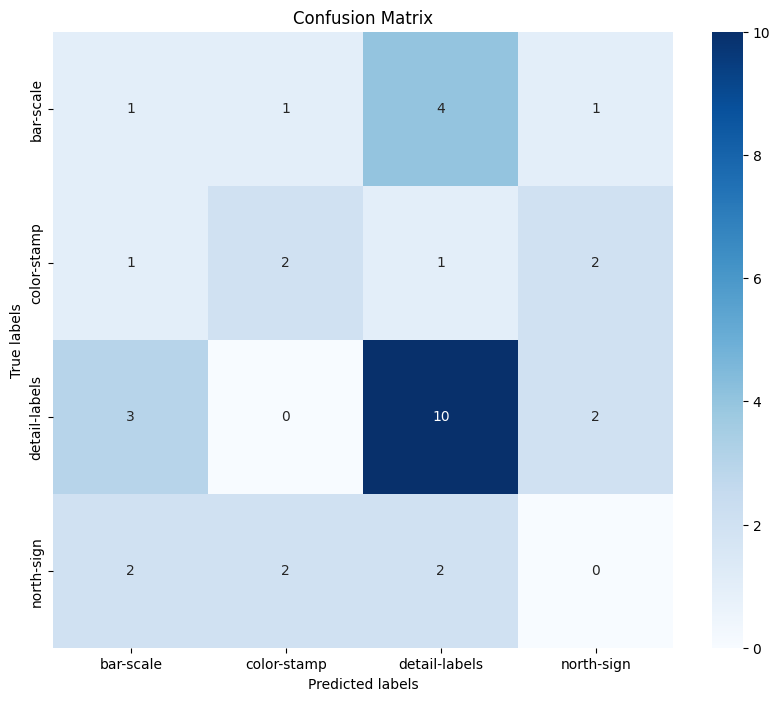

In [238]:
import torch
import time
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
 
def convert_to_detections(outputs, threshold=0.4):
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    bboxes_scaled = outputs.pred_boxes[0, keep].detach().cpu().numpy()
    probas = probas[keep].detach().cpu().numpy()
    return bboxes_scaled, probas
 
true_labels = []
pred_labels = []
 
test_time_start = time.time()
with torch.no_grad():
    for batch in tqdm(TEST_DATALOADER, desc="Testing"):
        pixel_values = batch['pixel_values']
        pixel_mask = batch.get('pixel_mask', None)
 
        labels = batch['labels']

        
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        bboxes, probas = convert_to_detections(outputs)
 
        # Get predicted labels
        batch_pred_labels = np.argmax(probas, axis=1)
        pred_labels.extend(batch_pred_labels)
 
        # Get true labels
        for ann in labels:
            if 'class_labels' in ann:
                true_labels.extend(ann['class_labels'].cpu().numpy())
            elif 'labels' in ann:
                true_labels.extend(ann['labels'].cpu().numpy())
            else:
                print("Warning: No label information found in annotation.")
                print("Annotation keys:", ann.keys())
 
        # Debugging: Print the current batch's true and predicted labels
        print(f"Batch true labels: {[ann['class_labels'].cpu().numpy() if 'class_labels' in ann else ann['labels'].cpu().numpy() for ann in labels]}")
        print(f"Batch predicted labels: {batch_pred_labels}")
 
test_time_end = time.time()
total_time = test_time_end - test_time_start
print(f"Time required for testing: {total_time:.2f} seconds")
 
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
 
# Ensure true_labels and pred_labels have the same length
min_len = min(len(true_labels), len(pred_labels))
true_labels = true_labels[:min_len]
pred_labels = pred_labels[:min_len]
 
print("True labels:", true_labels)
print("Predicted labels:", pred_labels)
 
# Define id2label mapping
id2label = {
    0: "bar-scale",
    1: "color-stamp",
    2: "detail-labels",
    3: "north-sign"
}
 
# Calculate and print classification metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f1 = f1_score(true_labels, pred_labels, average='macro')
error_rate = 1 - accuracy
 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print("\n")
 
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=list(id2label.values())))
 
# Create and plot confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=list(id2label.keys()))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(id2label.values()), yticklabels=list(id2label.values()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()